# Rental List Classification

In [60]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ggplot import *
import seaborn as sns
from colour import Color
%matplotlib inline

In [2]:
# read in the training data set
train_set = pd.read_json(r'..\data\train.json')
test_set = pd.read_json(r'..\data\test.json')
print("Read in training data set with size of {} * {}".format(train_set.shape[0], train_set.shape[1]))
print("Read in testing data set with size of {} * {}".format(test_set.shape[0], test_set.shape[1]))

Read in training data set with size of 49352 * 15
Read in testing data set with size of 74659 * 14


In [3]:
# seperate the features and the response
train_X = train_set.drop('interest_level', axis=1)
train_y = train_set['interest_level']


In [4]:
test_set.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address'],
      dtype='object')

In [5]:
train_set.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


## Data explorary analysis

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64


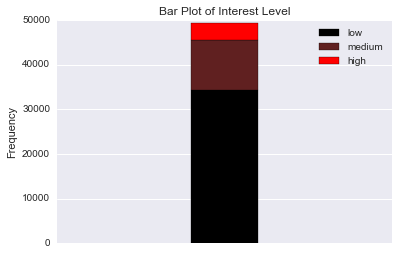

In [66]:
# Response var: interest_level
interest_level_count = train_set['interest_level'].value_counts()
print(interest_level_count)

# creaate gradient color bar for interest levels
red = Color("black")
level_c = list(red.range_to(Color("red"),len(interest_level_count)))



ax = plt.subplot(1, 1, 1)
for i in range(len(interest_level_count)): 
    ax.bar(0.2, interest_level_count[i], width=0.1, bottom=sum(interest_level_count[0:i]), label=interest_level_count.index[i], 
           color = level_c[i].rgb)
           
ax.set(xlim=(0, 0.5), xticks=(), title='Bar Plot of Interest Level', ylabel='Frequency')
plt.legend()
plt.show()


Descriptive stats of bb_ratio: 

count    49352.000000
mean         1.262346
std          0.874721
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64


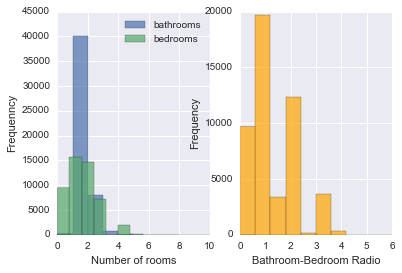

In [46]:
# Number of bedrooms, bathrooms
# create a new var: bathroom-bedroom ratio
# for those do not have a bedroom, assume they are studio and set the number of bedrooms to 1
bb_ratio = train_set['bedrooms'] / train_set['bathrooms'].apply(lambda x: x if x != 0 else 1)
print("Descriptive stats of bb_ratio: \n")
print(bb_ratio.describe())



for room in ('bathrooms', 'bedrooms'):
    ax = plt.subplot(1, 2, 1)
    train_set[room].hist(alpha=0.7, label=room)
ax.set(xlabel='Number of rooms', ylabel='Frequenncy')
ax.legend(loc=1)

ax = plt.subplot(1, 2, 2)
ax.hist(bb_ratio, color='orange', alpha=0.7)
ax.set(xlabel='Bathroom-Bedroom Radio', ylabel='Frequency')
plt.show()


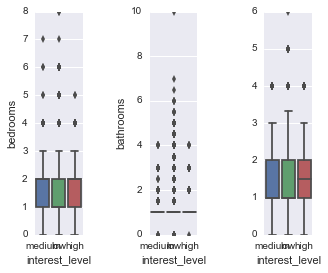

In [47]:
# Boxplots of number of bedroom, bathrooms and bb_ratio faceted by interest level
ax = plt.subplot(1, 6, 1)
sns.boxplot(x='interest_level', y='bedrooms', data=train_set, ax=ax)
ax = plt.subplot(1, 6, 3)
sns.boxplot(x='interest_level', y='bathrooms', data=train_set, ax=ax)
ax = plt.subplot(1, 6, 5)
sns.boxplot(x=train_set['interest_level'], y=bb_ratio, ax=ax)
plt.show()


In [85]:
# longitute and latitude
print('Stats of the vars: longitude, latitude:')
print(train_set[['longitude', 'latitude']].describe())

# find potential outliers with longitude = 0
print('\nStats of latitude when longitude = 0:')
print(train_set[train_set['longitude']==0]['latitude'].describe())
print('\ninteset levels when longitude = 0:')
print(train_set[train_set['longitude']==0]['interest_level'].value_counts())



Stats of the vars: longitude, latitude:
          longitude      latitude
count  49352.000000  49352.000000
mean     -73.955716     40.741545
std        1.177912      0.638535
min     -118.271000      0.000000
25%      -73.991700     40.728300
50%      -73.977900     40.751800
75%      -73.954800     40.774300
max        0.000000     44.883500

Stats of latitude when longitude = 0:
count    12
mean      0
std       0
min       0
25%       0
50%       0
75%       0
max       0
Name: latitude, dtype: float64

inteset levels when longitude = 0:
low       11
medium     1
Name: interest_level, dtype: int64


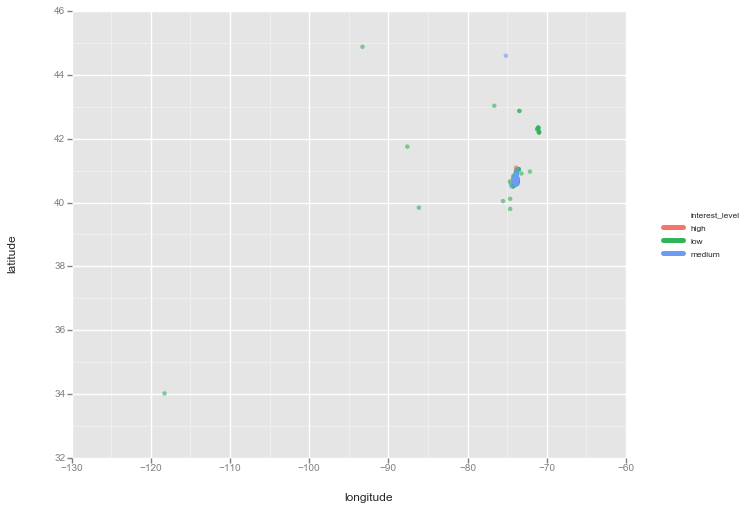

<ggplot: (121927004599)>


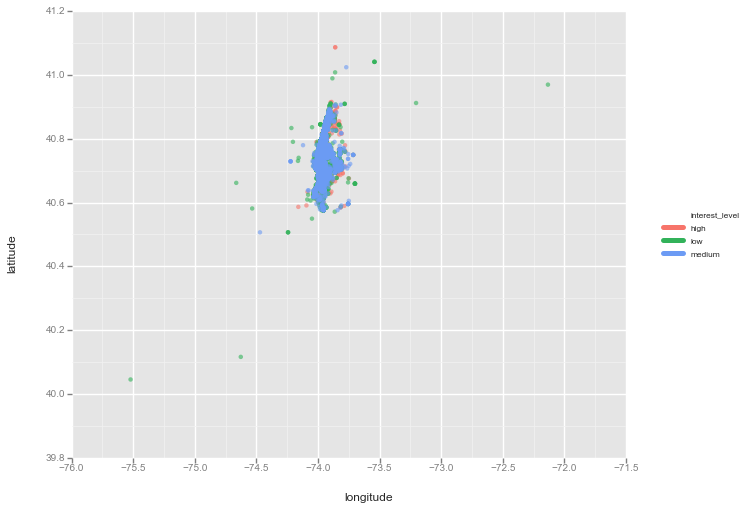

<ggplot: (-9223371914927037885)>


In [113]:
def zoomin_ll(data, condition):
    g = ggplot(data[condition], aes(x='longitude', y='latitude', color='interest_level')) + \
        geom_jitter(alpha=0.6)
    return g



# Let's zoom in (remove longitude = 0)
cond1 = train_set['longitude'] != 0
g1 = zoomin_ll(train_set, cond1)

# let's furthur zoom in (longtitude: 40~42, latitude: -80~-70)
cond2 = (train_set['latitude']<=42) & (train_set['latitude']>=40) & (train_set['longitude']>=-80) & (train_set['longitude']<=-70)
g2 = zoomin_ll(train_set, cond2)

print(g1)
print(g2)

